In [1]:
use_gpu = True
data_dir = '/home/victor/data'

In [42]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport bigan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [892]:
from collections import defaultdict
from psutil import cpu_count
from itertools import chain

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import init, Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

try:
    from bokeh.io import push_notebook, output_notebook, show
    from bokeh.plotting import figure
    output_notebook()
    def dynamic_image_figure(w,h):
        """create an RGB image figure in current cell and return an update function for it"""
        def im2bokeh(img):
            img = (img*255).astype(np.uint8)
            img = np.dstack([img, np.ones(img.shape[:2], np.uint8) * 255])
            img = np.squeeze(img.view(np.uint32))
            return img[::-1]
        p = figure(plot_width=w, plot_height=h, x_range=(0,1), y_range=(0,1), tools='')
        p.xaxis.visible = False
        p.yaxis.visible = False
        r = p.image_rgba([im2bokeh(np.zeros((w,h,3)))],0,0,1,1)
        show(p, notebook_handle=True)
        def update(img):
            r.data_source.data['image'][0] = im2bokeh(img)
            push_notebook()
        return update
except Exception:
    print('install bokeh for dynamic plots')
    def dynamic_image_figure(*args):
        return lambda x: None

Loading BokehJS ...

In [5]:
# get a image data set into a tensor, scale to (-1, 1), discarding labels
def torchvision_dataset(dset_fn, train=True):
    dset = dset_fn(
        data_dir,
        train=train,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]),
        target_transform=None,
        download=True)
    return torch.stack(list(zip(*dset))[0])*2-1

In [6]:
cifar = torchvision_dataset(datasets.CIFAR10, train=True)
cifar_test = torchvision_dataset(datasets.CIFAR10, train=False)
print(cifar.size())

Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3, 32, 32])


In [7]:
batch_size = 64

In [8]:
num_workers = cpu_count() if use_gpu else 0

X_train = DataLoader(cifar, batch_size=batch_size, shuffle=True,
                     num_workers=num_workers, pin_memory=use_gpu)
X_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False,
                   num_workers=num_workers, pin_memory=use_gpu)

In [943]:
class ChannelsToLinear(nn.Linear):
    """Flatten a Variable to 2d and apply Linear layer"""
    def forward(self, x):
        b = x.size(0)
        return super().forward(x.view(b,-1))

class LinearToChannels2d(nn.Linear):
    """Reshape 2d Variable to 4d after Linear layer"""
    def __init__(self, m, n, w=1, h=None, **kw):
        h = h or w
        super().__init__(m, n*w*h, **kw)
        self.w = w
        self.h = h
    def forward(self, x):
        b = x.size(0)
        return super().forward(x).view(b, -1, self.w, self.h)
    
class ResBlockSE(nn.Module):
    """Resnet block with Squeeze-Excitation"""
    def __init__(self, c,
                 activation=nn.LeakyReLU, norm=nn.BatchNorm2d,
                 init_gain=1, squeeze_factor=8
                ):
        super().__init__()
        self.a1 = activation()
        self.a2 = activation()
        self.norm1 = norm and norm(c)
        self.norm2 = norm and norm(c)

        to_init = []
        self.conv1 = nn.Conv2d(
            c, c, 3, 1, 1, bias=bool(norm))
        to_init.append(self.conv1.weight)           
        self.conv2 = nn.Conv2d(
            c, c, 3, 1, 1, bias=bool(norm))
        to_init.append(self.conv2.weight)

#         self.lin1 = nn.Linear(c, c//squeeze_factor)
#         to_init.append(self.lin1.weight)
#         self.lin2 = nn.Linear(c//squeeze_factor, c)
#         to_init.append(self.lin2.weight)
        
#         self.a3 = activation()

        # init
        for w in to_init:
            init.xavier_uniform(w, init_gain)

    def forward(self, x):
        y = self.conv1(x)
        if self.norm1:
            y = self.norm1(y)
        y = self.a1(y)

        y = self.conv2(y)
        if self.norm2:
            y = self.norm2(y)

#         z = y.mean(-1).mean(-1)
#         z = self.lin1(z)
#         z = self.a3(z)
#         z = self.lin2(z)
#         z = F.sigmoid(z)

#         y = y*z.view(*z.size()[:2],1,1)

        return self.a2(x+y)
    
class ModuleTree(nn.Module):
    def __init__(self, children, parent):
        super().__init__()
        self.child_nodes = nn.ModuleList(children)
        self.parent = parent
        
    def forward(self, *args):
        x = torch.cat([
            child(x) for child, x in zip(self.child_nodes, args)
        ],1)
        return self.parent(x)

class ReparamGaussian(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        mu, log_sigma = x.chunk(2, dim=-1)
        sigma = log_sigma.exp()
        eps = Variable(torch.randn(mu.size()))
        if x.is_cuda:
            eps = eps.cuda()
        return mu + eps*sigma
    
# class ConditionalSequential(nn.Sequential):
#     """nn.Sequential but with a conditional argument to forward.
#     conditional_layers: indices of layers which accept the conditional input.
#         By default, all layers.
#     """
#     def __init__(self, *args, conditional_layers=None):
#         self.conds = conditional_layers
#         super().__init__(*args)
        
#     def forward(self, x, z):
#         for i,layer in enumerate(self):
#             if not self.conds or i in self.conds:
#                 x = layer(x, z)
#             else:
#                 x = layer(x)
#         return x

In [946]:
latent_dim = 64

In [947]:
# encoder network
h = 128
resample = nn.AvgPool2d
norm = nn.BatchNorm2d#None
a, g = lambda: nn.LeakyReLU(.1), init.calculate_gain('leaky_relu', .1)

#from the ALI paper
E = nn.Sequential(
    nn.Conv2d(3,32,5,1, bias=False), norm(32), a(),
    nn.Conv2d(32,64,4,2, bias=False), norm(64), a(),
    nn.Conv2d(64,128,4,1, bias=False), norm(128), a(),
    nn.Conv2d(128,256,4,2, bias=False), norm(256), a(),
    nn.Conv2d(256,512,4,1, bias=False), norm(512), a(),
    nn.Conv2d(512,512,1, bias=False), norm(512), a(),
    ChannelsToLinear(512,latent_dim*2),
    ReparamGaussian()
)
# E = nn.Sequential(
#     nn.Conv2d(3,32,5,1, bias=False), norm(32), a(),
#     nn.Conv2d(32,64,4,1, bias=False), resample(2), norm(64), a(),
#     nn.Conv2d(64,128,4,1, bias=False), norm(128), a(),
#     nn.Conv2d(128,256,4,1, bias=False), resample(2), norm(256), a(),
#     nn.Conv2d(256,512,3,1, bias=False), norm(512), a(),
#     nn.Conv2d(512,512,1, bias=False), norm(512), a(),
#     ChannelsToLinear(512,latent_dim)
# )
nparams = 0
for layer in E:
    if hasattr(layer, 'weight'):
        if layer.weight.dim() > 1:
#             init.xavier_normal(layer.weight)
            init.normal(layer.weight, 0, 0.01)
        else:
            init.normal(layer.weight, 0, g)
        nparams += layer.weight.numel()
    if hasattr(layer, 'bias'):
        if not layer.bias is None:
            init.constant(layer.bias, 0)
            nparams += layer.bias.numel()
print('{} parameters'.format(nparams))


# E = nn.Sequential(
#     nn.Conv2d(3,h,5,1,2), resample(2), a(),
#     ResBlockSE(h, activation=a, norm=norm, init_gain=g), resample(2),
#     ResBlockSE(h, activation=a, norm=norm, init_gain=g), resample(2),
#     ResBlockSE(h, activation=a, norm=norm, init_gain=g), resample(2),
#     ChannelsToLinear(h*4, latent_dim), nn.Tanh()
# )
# for layer in (0,9):
#     init.xavier_uniform(E[layer].weight, g)

t = Variable(torch.randn(batch_size,3,32,32))

assert E(t).size() == (batch_size,latent_dim)

3118496 parameters


In [948]:
# generator network
h = 128
norm = nn.BatchNorm2d#None
a, g = lambda: nn.LeakyReLU(.1), init.calculate_gain('leaky_relu', .1)
resample = lambda x: nn.Upsample(scale_factor=x)

#from the ALI paper
G = nn.Sequential(
    LinearToChannels2d(latent_dim, 256, 4, 4), norm(256), a(),
    nn.ConvTranspose2d(256,128,4,2, bias=False), norm(128), a(),
    nn.ConvTranspose2d(128,64,4,1, bias=False), norm(64), a(),
    nn.ConvTranspose2d(64,32,4,2, bias=False), norm(32), a(),
    nn.ConvTranspose2d(32,32,5,1, bias=False), norm(32), a(),
    nn.Conv2d(32,32,1, bias=False), norm(32), a(),
    nn.Conv2d(32,3,1, bias=True), nn.Tanh()
)
#similar but faster and without checkerboarding
# G = nn.Sequential(
#     LinearToChannels2d(latent_dim, 512, 1, 1), norm(512), a(),
# #     nn.Conv2d(512, 512, 1, bias=False), norm(512), a(),
#     nn.ConvTranspose2d(512, 256, 2, bias=False), norm(256), a(),
# #     nn.ConvTranspose2d(512, 256, 1, bias=False), resample(2), norm(256), a(),
# #     LinearToChannels2d(latent_dim, 256, 2, 2), norm(256), a(),
#     nn.ConvTranspose2d(256,128,3,1, bias=False), resample(2), norm(128), a(),
#     nn.ConvTranspose2d(128,64,4,1, bias=False), norm(64), a(),
#     nn.ConvTranspose2d(64,32,4,1, bias=False), resample(2), norm(32), a(),
#     nn.ConvTranspose2d(32,32,5,1, bias=False), norm(32), a(),
#     nn.Conv2d(32,32,1, bias=False), norm(32), a(),
#     nn.Conv2d(32,3,1, bias=True), nn.Tanh()
# )
nparams = 0
for layer in G:
    if hasattr(layer, 'weight'):
        if layer.weight.dim() > 1:
#             init.xavier_normal(layer.weight)
            init.normal(layer.weight, 0, 0.01)
        else:
            init.normal(layer.weight, 0, g)
        nparams += layer.weight.numel()
    if hasattr(layer, 'bias'):
        if not layer.bias is None:
            init.constant(layer.bias, 0)
            nparams += layer.bias.numel()
print('{} parameters'.format(nparams))
    
# G = nn.Sequential(
#     LinearToChannels2d(latent_dim,h,2,2), a(),
#     ResBlockSE(h, activation=a, norm=norm, init_gain=g), resample(2),
#     ResBlockSE(h, activation=a, norm=norm, init_gain=g), resample(2),
#     ResBlockSE(h, activation=a, norm=norm, init_gain=g), resample(2),
#     nn.Conv2d(h, h//4, 3, 1, 1), a(), resample(2),
#     nn.Conv2d(h//4, 3, 3, 1, 1), nn.Tanh()
# )
# for layer in (0,8,11):
#     init.xavier_uniform(G[layer].weight, g)

t = Variable(torch.randn(batch_size,latent_dim))
t = G(t)
assert t.size() == (batch_size,3,32,32), t.size()

982179 parameters


In [949]:
# discriminator network
h = 128
hz = 512
resample = nn.AvgPool2d
norm = nn.BatchNorm2d
a, g = lambda: nn.LeakyReLU(.1), init.calculate_gain('leaky_relu', .1)

# similar to ALI paper but with BN+leakyrelu instead of dropout+maxout, and half sized linear layers
D = ModuleTree([
    nn.Sequential(
        nn.Conv2d(3,32,5,1, bias=False), norm(32), a(),
        nn.Conv2d(32,64,4,1, bias=False), resample(2), norm(64), a(),#     nn.Conv2d(32,64,4,2, bias=False), norm(64), a(),
        nn.Conv2d(64,128,4,1, bias=False), norm(128), a(),
        nn.Conv2d(128,256,4,1, bias=False), resample(2), norm(256), a(),#     nn.Conv2d(128,256,4,2, bias=False), norm(256), a(),
#         nn.Conv2d(256,512,3,1, bias=False), norm(512), a(),#     nn.Conv2d(256,512,4,1, bias=False), norm(512), a(),
        ChannelsToLinear(256*3*3, hz//2)#         ChannelsToLinear(256*4*4, hz//2)
    ),
    nn.Sequential(
        nn.Linear(latent_dim, hz//2), a(),
        nn.Linear(hz//2, hz//2)
    )],
    nn.Sequential(
        a(),
        nn.Linear(hz, hz), a(),
        nn.Linear(hz, hz), a(),
        nn.Linear(hz, 1), nn.Sigmoid()
    )
)

nparams = 0
for layer in chain(D.parent, *D.child_nodes):
    if hasattr(layer, 'weight'):
        if layer.weight.dim() > 1:
#             init.xavier_normal(layer.weight)
            init.normal(layer.weight, 0, 0.01)
        else:
            init.normal(layer.weight, 0, g)
        nparams += layer.weight.numel()
    if hasattr(layer, 'bias'):
        if not layer.bias is None:
            init.constant(layer.bias, 0)
            nparams += layer.bias.numel()
print('{} parameters'.format(nparams))

# D = ModuleTree([
#     nn.Sequential(
#         nn.Conv2d(3,h,5,1,2), resample(2), a(),
#         ResBlockSE(h, activation=a, norm=norm, init_gain=g), resample(2),
#         ResBlockSE(h, activation=a, norm=norm, init_gain=g), resample(2),
#         ResBlockSE(h, activation=a, norm=norm, init_gain=g), resample(2),
#         ChannelsToLinear(h*4, hz//2)
#     ),
#     nn.Sequential(
#         nn.Linear(latent_dim, hz//2), a(),
#         nn.Linear(hz//2, hz//2)
#     )],
#     nn.Sequential(
#         a(),
#         nn.Linear(hz, hz), a(),
#         nn.Linear(hz, hz), a(),
#         nn.Linear(hz, 1), nn.Sigmoid()
#     )
# )
# for layer in (0,9):
#     init.xavier_uniform(D.child_nodes[0][layer].weight, g)
# for layer in (0,):
#     init.xavier_uniform(D.child_nodes[1][layer].weight, g)
# for layer in (1,3):
#     init.xavier_uniform(D.parent[layer].weight, g)
    
t = Variable(torch.randn(batch_size,3,32,32))
tz = Variable(torch.rand(batch_size, latent_dim))
assert D(t, tz).size() == (batch_size,1)

1889825 parameters


In [950]:
model = bigan.BiGAN(E, G, D, latent_dim)
if use_gpu:
    model = model.cuda()
diag = []

In [951]:
# model.load_state_dict(torch.load('../models/cifar10_dim_{}_lambda_{}_zlambd_{}_epochs_{}.torch'.format(
#         latent_dim, model.lambd, model.z_lambd, 8
#     )))

In [952]:
n_samples = 14
n_rows = 3
pad = 1
scale = 2
update_fig = dynamic_image_figure(
    scale*(32*n_samples+pad*(n_samples+1)),
    scale*(32*n_rows+pad*(n_rows+1))
)
z = model.sample_prior(n_samples)

def vis():
    model.eval()
    x = model(z, mode='generate')
    x_real = model._wrap(cifar_test[:n_samples])
    x_hat = model(x_real, mode='reconstruct')
    x = torch.cat((x,x_real,x_hat),0)
    return make_grid(
        x.data, nrow=n_samples, range=(-1,1), normalize=True, padding=pad
    ).cpu().numpy().transpose(1,2,0).copy()
update_fig(vis())

def log_fn(d):
    d = pd.DataFrame(d)
    diag.append(d)
    print(d)
    update_fig(vis())
    
def checkpoint_fn(model, epoch):
    path =  '../models/cifar10_dim_{}_epoch_{}.torch'.format(
        model.latent_dim, epoch
    )
    torch.save(model.state_dict(), path)

In [953]:
model.fit(
    X_train, X_test,
    n_epochs=6,
#     n_epochs=6*25, n_batches=32,
    opt_fn = torch.optim.Adam,
    opt_params=({'lr':1e-4, 'betas':(.5,.999)}, {'lr':1e-4, 'betas':(.5,.999)}),
    log_fn=log_fn, log_every=1,
    checkpoint_fn=checkpoint_fn, checkpoint_every=2
)

            train     valid
D_loss   0.492385  0.925226
EG_loss  8.353892  4.019636


            train     valid
D_loss   0.951376  1.159275
EG_loss  3.393981  2.673210


            train     valid
D_loss   1.093192  1.283261
EG_loss  2.559688  3.064614


            train     valid
D_loss   1.113070  1.025213
EG_loss  2.467507  2.679307


            train     valid
D_loss   1.105794  1.355796
EG_loss  2.489465  2.599555


            train     valid
D_loss   1.082334  1.147331
EG_loss  2.593220  3.051378



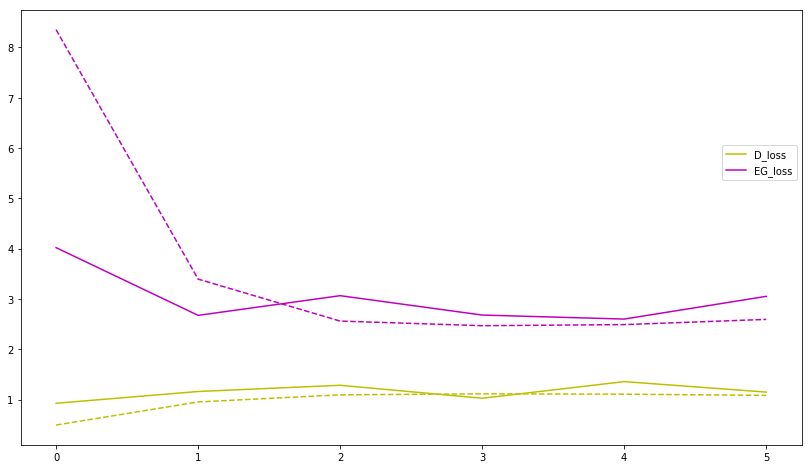

In [954]:
fig, ax = plt.subplots(1,1,figsize=(14,8))
diagnostic = pd.concat([pd.DataFrame(d.stack(), columns=[i]).T for i,d in enumerate(diag)])
cols = list('rgbcmy')
colors = defaultdict(lambda: cols.pop())
for c in diagnostic:
    component, dataset = c
    kw = {}
    if dataset=='valid':
        kw['label'] = component
    else:
        kw['ls'] = '--'
    ax.plot(diagnostic[c].values, c=colors[component], **kw)
ax.legend(bbox_to_anchor=(1, 0.7))

In [955]:
model.eval()
pass

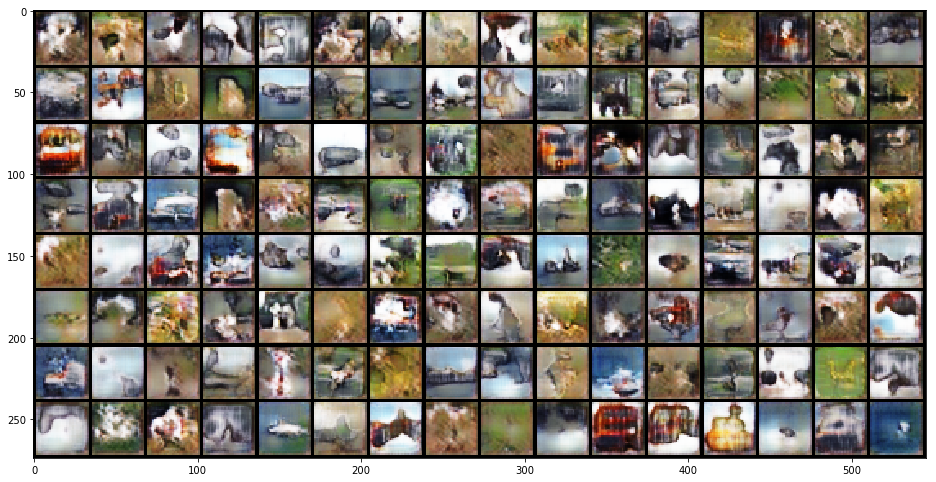

In [956]:
# samples
z, x = model(128, mode='sample')
fig, ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(make_grid(
    x.data, nrow=16, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')
pass

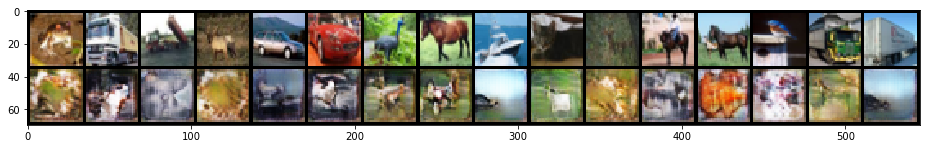

In [957]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
# training reconstructions
x = cifar[:16]
z, x_rec = model(x)
ax.imshow(make_grid(
    torch.cat((x, x_rec.cpu().data)), nrow=16, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')
pass

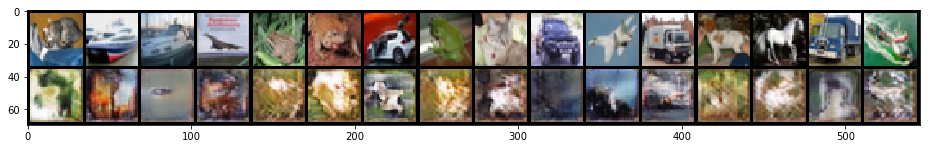

In [958]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
# test reconstructions
x = cifar_test[:16]
z, x_rec = model(x)
ax.imshow(make_grid(
    torch.cat((x, x_rec.cpu().data)), nrow=16, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')
pass

### pairwise distances give a sense of how encoded z are distributed compared the prior:

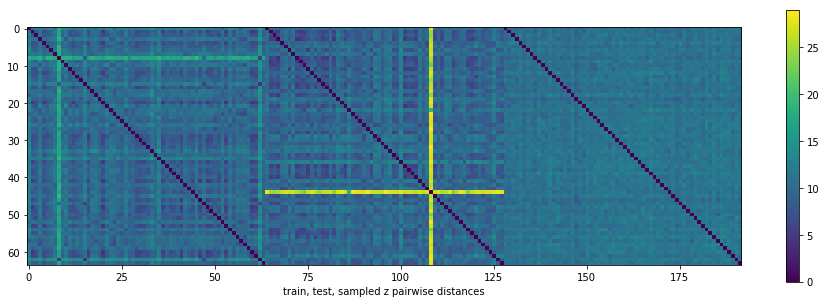

In [959]:
fig, ax = plt.subplots(1,1,figsize=(16,5))
n = 64

import scipy.spatial
train_z = model(cifar[:n], mode='encode').data.cpu().numpy()
test_z = model(cifar_test[:n], mode='encode').data.cpu().numpy()
sampled_z = model.sample_prior(n).data.cpu().numpy()
train_cdist = scipy.spatial.distance.cdist(train_z,train_z)
test_cdist = scipy.spatial.distance.cdist(test_z,test_z)
sampled_cdist = scipy.spatial.distance.cdist(sampled_z,sampled_z)
cax = ax.imshow(np.concatenate((train_cdist, test_cdist, sampled_cdist),1))
fig.colorbar(cax)
ax.set_xlabel('train, test, sampled z pairwise distances')
pass

### interpolation

In [960]:
def slerp(z0, z1, t):
    """Spherical linear interpolation over last dimension:
    z0.shape = z1.shape = (m,...n, d) and t.shape = (q,) -> (q, m,...n, d)
    Project to unit sphere and linearly interpolate magnitudes.
    """
    m0, m1 = (np.linalg.norm(z, 2, -1) for z in (z0, z1))
    p0, p1 = z0/np.expand_dims(m0,-1), z1/np.expand_dims(m1,-1)
    omega = np.arccos((p0*p1).sum(-1))
    while t.ndim<=omega.ndim:
        t = np.expand_dims(t,-1)
    sin_omega = np.sin(omega)
    t0 = np.sin((1-t)*omega)/sin_omega
    t1 = np.sin(t*omega)/sin_omega
    lim = abs(omega)<1e-15
    t1[lim] = t[lim]
    t0[lim] = (1-t)[lim]
    t0, t1 = np.expand_dims(t0, -1), np.expand_dims(t1, -1)
    m = np.expand_dims((1-t)*m0 + t*m1, -1)
    return m*(t0*p0 + t1*p1)
def slerp4(z, t):
    # z (4,n) and t (m,) -> z' (m, m, n)
    return slerp(
        slerp(z[0], z[1], t),
        slerp(z[2], z[3], t),
        t)

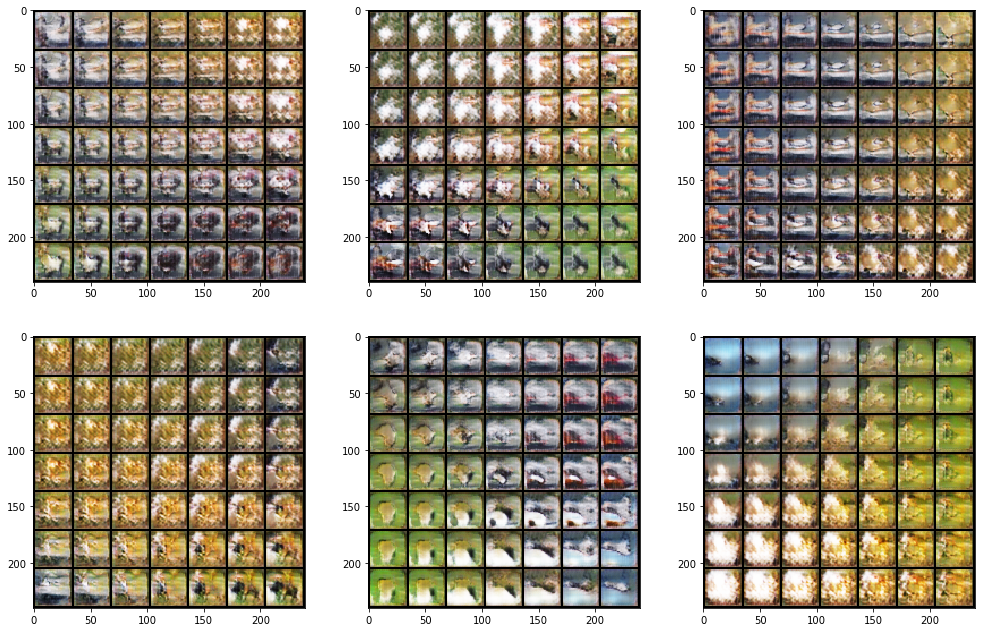

In [961]:
n = 7
fig,ax = plt.subplots(2,3,figsize=(17,11))
for ax in ax.flatten():
    x = cifar_test[torch.LongTensor(np.random.randint(len(cifar_test),size=4))]
    z = model(x, mode='encode')
    z = slerp4(z.data.cpu().numpy(), np.linspace(0,1,n)).reshape(n*n,-1)
    x_rec = model(z, mode='generate')
    ax.imshow(make_grid(
        x_rec.cpu().data, nrow=n, range=(-1,1), normalize=True
    ).numpy().transpose(1,2,0), interpolation='nearest')